# 사용 패키지

In [ ]:
!pip install xgboost

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

#import lightgbm as lgb
#import xgboost as xgb
#import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# 데이터 로드

In [3]:
total = pd.read_csv('./Data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
total.columns = ['date', 'hour', 'company', 'gas']


companys = total['company'].unique()
company_map = dict()
for i, company in enumerate(companys):
    company_map[company] = i
#total['company'] = total['company'].map(company_map)
total['date'] = pd.to_datetime(total['date'])
total['year'] = total['date'].dt.year
total['month'] = total['date'].dt.month
total['day'] = total['date'].dt.day
total['weekday'] = total['date'].dt.weekday
total['weekend'] = 0
total.loc[total['weekday'] >= 5, 'weekend'] = 1


total = total[total['month'].isin([1,2,3])]
total.head(-5)
#total.shape

,date,hour,company,gas,year,month,day,weekday,weekend
0,2013-01-01,1,0,2497.129,2013,1,1,1,0
1,2013-01-01,2,0,2363.265,2013,1,1,1,0
2,2013-01-01,3,0,2258.505,2013,1,1,1,0
3,2013-01-01,4,0,2243.969,2013,1,1,1,0
4,2013-01-01,5,0,2344.105,2013,1,1,1,0
...,...,...,...,...,...,...,...,...,...
361478,2018-03-31,15,6,181.907,2018,3,31,5,1
361479,2018-03-31,16,6,166.607,2018,3,31,5,1
361480,2018-03-31,17,6,173.503,2018,3,31,5,1
361481,2018-03-31,18,6,191.135,2018,3,31,5,1


In [6]:
#company_map
onehotencoder = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(total[['company']]).toarray()
X[:5]

#To add this back into the original dataframe 
company_one_hot = pd.DataFrame(X, columns = ["company_"+str(int(i)) for i in range(X.shape[1])]) 
total = pd.concat([total, company_one_hot], axis=1)

#droping the country column 
total = total.drop(['company'], axis=1) 

#printing to verify 
#print(df.head())

total.head()


,date,hour,gas,year,month,day,weekday,weekend,company_0,company_1,company_2,company_3,company_4,company_5,company_6
0,2013-01-01,1.0,2497.129,2013.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,2.0,2363.265,2013.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,3.0,2258.505,2013.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,4.0,2243.969,2013.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,5.0,2344.105,2013.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:

temps = []
for year in range(2013, 2019):
    temp = pd.read_csv(f'./Data/temperature_{year}.csv', encoding='cp949')
    #temp.columns = header
    temp = temp[['일시', '기온(°C)']]
    temp.columns = ['datetime', 'temperature']
    temp['datetime'] = pd.to_datetime(temp['datetime'])
    temp['year'] = temp['datetime'].dt.year
    temp['month'] = temp['datetime'].dt.month
    temp['day'] = temp['datetime'].dt.day
    temp['weekday'] = temp['datetime'].dt.weekday
    temp['hour'] = temp['datetime'].dt.hour + 1
    print(temp.shape)
    temps.append(temp)




(8760, 7)
(8760, 7)
(8760, 7)
(8784, 7)
(8756, 7)
(8759, 7)


In [52]:
temp_2019 = pd.read_csv('./Data/temperature_2019.csv', encoding='cp949')
temp_2019 = temp_2019[['일시', '기온(°C)']]
temp_2019.columns = ['datetime', 'temperature']
temp_2019['datetime'] = pd.to_datetime(temp_2019['datetime'])
temp_2019['year'] = temp_2019['datetime'].dt.year
temp_2019['month'] = temp_2019['datetime'].dt.month
temp_2019['day'] = temp_2019['datetime'].dt.day
temp_2019['weekday'] = temp_2019['datetime'].dt.weekday
temp_2019['hour'] = temp_2019['datetime'].dt.hour + 1

# 전처리

In [8]:
# interpolation for 2015

print(temps[2].head())
temps[2]['datetime'].iloc[0] = pd.to_datetime("2015-01-01 00:00:00")
temps[2]['year'].iloc[0] = 2015
temps[2]['month'].iloc[0] = 1
temps[2]['day'].iloc[0] = 1
temps[2]['weekday'].iloc[0] = 3
temps[2]['hour'].iloc[0] = 1

print(temps[2].head())


             datetime  temperature  year  month  day  weekday  hour
0 2014-12-31 23:00:00         -6.2  2014     12   31        2    24
1 2015-01-01 01:00:00         -7.4  2015      1    1        3     2
2 2015-01-01 02:00:00         -8.0  2015      1    1        3     3
3 2015-01-01 03:00:00         -8.4  2015      1    1        3     4
4 2015-01-01 04:00:00         -8.8  2015      1    1        3     5
             datetime  temperature  year  month  day  weekday  hour
0 2015-01-01 00:00:00         -6.2  2015      1    1        3     1
1 2015-01-01 01:00:00         -7.4  2015      1    1        3     2
2 2015-01-01 02:00:00         -8.0  2015      1    1        3     3
3 2015-01-01 03:00:00         -8.4  2015      1    1        3     4
4 2015-01-01 04:00:00         -8.8  2015      1    1        3     5


/Users/woojaebyun/miniforge3/envs/mlp/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
# interpolation for 2017

missing_indices = pd.isnull(temps[-2].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0]
print(missing_indices)

print(temps[-2].iloc[6448:6450])    
print(temps[-2].iloc[6829:6835])

calc_temp = temps[-2]['temperature'].iloc[6448:6450].mean()
print(calc_temp)
line = pd.DataFrame({"datetime": pd.to_datetime("2017-09-26 17:00:00"), 'temperature': calc_temp, "year": 2017, 'month': 9, 'day':26, \
                  'weekday':1, 'hour': 18}, index=[6449] )


lines = \
pd.DataFrame({"datetime": [pd.to_datetime("2017-10-12 15:00:00"), pd.to_datetime("2017-10-12 16:00:00"), pd.to_datetime("2017-10-12 17:00:00")], \
              'temperature': [13.5, 13.3, 13.1], \
              "year": [2017, 2017, 2017], 'month': [10, 10, 10], \
              'day':[12,12,12], 'weekday':[3,3,3], 'hour': [16,17,18]}, \
              index=[6830, 6831, 6832] )



temps[-2] = pd.concat([temps[-2].iloc[:6449], line, temps[-2].iloc[6449:6830], lines, temps[-2].iloc[6830:]]).reset_index(drop=True)

print(temps[-2].iloc[6448:6451])    
print(temps[-2].iloc[6829:6836])

[6449 6831 6832 6833]
                datetime  temperature  year  month  day  weekday  hour
6448 2017-09-26 16:00:00         30.4  2017      9   26        1    17
6449 2017-09-26 18:00:00         27.9  2017      9   26        1    19
                datetime  temperature  year  month  day  weekday  hour
6829 2017-10-12 14:00:00         13.7  2017     10   12        3    15
6830 2017-10-12 18:00:00         12.8  2017     10   12        3    19
6831 2017-10-12 19:00:00         11.5  2017     10   12        3    20
6832 2017-10-12 20:00:00         10.6  2017     10   12        3    21
6833 2017-10-12 21:00:00         10.2  2017     10   12        3    22
6834 2017-10-12 22:00:00          9.7  2017     10   12        3    23
29.15
                datetime  temperature  year  month  day  weekday  hour
6448 2017-09-26 16:00:00        30.40  2017      9   26        1    17
6449 2017-09-26 17:00:00        29.15  2017      9   26        1    18
6450 2017-09-26 18:00:00        27.90  2017      

/var/folders/cy/y3tvnwx10nqc9qqg0b1wb7wr0000gn/T/ipykernel_89172/2936941575.py:3: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  missing_indices = pd.isnull(temps[-2].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0]


In [10]:
# interpolation for 2018

print(pd.isnull(temps[-1].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0])
print(temps[-1].iloc[7985:7987])

calc_temp = temps[-1]['temperature'].iloc[7985:7987].mean()
print(calc_temp)
line = pd.DataFrame({"datetime": pd.to_datetime("2018-11-29 18:00:00"), 'temperature': calc_temp, "year": 2018, 'month': 11, 'day':29, \
                  'weekday':3, 'hour': 19}, index=[7986] )
temps[-1] = pd.concat([temps[-1].iloc[:7986], line, temps[-1].iloc[7986:]]).reset_index(drop=True)
                  
                  
print(temps[-1].iloc[7985:7987])


for i in range(len(temps)):
    print(temps[i].shape)


[7986]
                datetime  temperature  year  month  day  weekday  hour
7985 2018-11-29 17:00:00          5.8  2018     11   29        3    18
7986 2018-11-29 19:00:00          5.2  2018     11   29        3    20
5.5
                datetime  temperature  year  month  day  weekday  hour
7985 2018-11-29 17:00:00          5.8  2018     11   29        3    18
7986 2018-11-29 18:00:00          5.5  2018     11   29        3    19
(8760, 7)
(8760, 7)
(8760, 7)
(8784, 7)
(8760, 7)
(8760, 7)


/var/folders/cy/y3tvnwx10nqc9qqg0b1wb7wr0000gn/T/ipykernel_89172/2492857734.py:3: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  print(pd.isnull(temps[-1].resample('1H', on='datetime', base=1).mean()).any(1).to_numpy().nonzero()[0])


In [11]:
temp_combined = pd.concat(temps, axis = 0)
temp_combined.reset_index(inplace=True, drop=True)
temp_combined.shape # should be 52584

(52584, 7)

In [12]:
join_df = pd.merge(total, temp_combined, how='left', left_on=['year', 'month', 'day', 'weekday', 'hour'], right_on=['year', 'month', 'day', 'weekday', 'hour'])
join_df.drop('datetime', axis=1, inplace=True)


print(join_df.shape)
print(total.shape)


print(join_df.iloc[:20])
print(total.iloc[:20])

(158016, 16)
(158016, 15)
         date  hour       gas    year  month  day  weekday  weekend  \
0  2013-01-01   1.0  2497.129  2013.0    1.0  1.0      1.0      0.0   
1  2013-01-01   2.0  2363.265  2013.0    1.0  1.0      1.0      0.0   
2  2013-01-01   3.0  2258.505  2013.0    1.0  1.0      1.0      0.0   
3  2013-01-01   4.0  2243.969  2013.0    1.0  1.0      1.0      0.0   
4  2013-01-01   5.0  2344.105  2013.0    1.0  1.0      1.0      0.0   
5  2013-01-01   6.0  2390.961  2013.0    1.0  1.0      1.0      0.0   
6  2013-01-01   7.0  2378.457  2013.0    1.0  1.0      1.0      0.0   
7  2013-01-01   8.0  2518.921  2013.0    1.0  1.0      1.0      0.0   
8  2013-01-01   9.0  2706.481  2013.0    1.0  1.0      1.0      0.0   
9  2013-01-01  10.0  2832.057  2013.0    1.0  1.0      1.0      0.0   
10 2013-01-01  11.0  2895.185  2013.0    1.0  1.0      1.0      0.0   
11 2013-01-01  12.0  2689.361  2013.0    1.0  1.0      1.0      0.0   
12 2013-01-01  13.0  2425.537  2013.0    1.0  1.0  

In [13]:
daily_temp = join_df[['temperature']].groupby([ join_df['month'], join_df['day'], join_df['hour'] ]).apply(lambda c: c.mean())
print(daily_temp.shape)
daily_temp

(2184, 1)


temperature
month day  hour             
1.0   1.0  1.0     -2.683333
           2.0     -3.116667
           3.0     -3.483333
           4.0     -3.716667
           5.0     -4.050000
...                      ...
3.0   31.0 20.0    12.883333
           21.0    11.800000
           22.0    11.083333
           23.0    10.450000
           24.0     9.950000

[2184 rows x 1 columns]

In [56]:
#features = ['temperature', 'company', 'month', 'day', 'weekday', 'hour', 'year']
features = ['temperature', 'month', 'day', 'hour', 'weekend', 'company_0', 'company_1', 'company_2', 'company_3', \
            'company_4', 'company_5', 'company_6']


x = join_df[features]
y = join_df['gas']

print(x.iloc[:5])
print(y.iloc[:5])

    
    

   temperature  month  day  hour  weekend  company_0  company_1  company_2  \
0         -8.3    1.0  1.0   1.0      0.0        1.0        0.0        0.0   
1         -8.5    1.0  1.0   2.0      0.0        1.0        0.0        0.0   
2         -8.4    1.0  1.0   3.0      0.0        1.0        0.0        0.0   
3         -8.1    1.0  1.0   4.0      0.0        1.0        0.0        0.0   
4         -8.2    1.0  1.0   5.0      0.0        1.0        0.0        0.0   

   company_3  company_4  company_5  company_6  
0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0  
0    2497.129
1    2363.265
2    2258.505
3    2243.969
4    2344.105
Name: gas, dtype: float64


In [ ]:
train_x_lst = []
train_y_lst   = []

val_x_lst = []
val_y_lst = []

for year in range(2013, 2019):
    train = join_df[join_df['year'] != year].reset_index(drop = True)
    val   = join_df[join_df['year'] == year].reset_index(drop = True)
    
    train_x = train[features]
    train_y = train['gas']
    train_x = train_x.values
    train_y = np.expand_dims(train_y.values, axis = 1)
    
    val_x = val[features]
    val_y = val['gas']
    val_x = val_x.values
    val_y = np.expand_dims(val_y.values, axis = 1)
    
    train_x_lst.append(train_x)
    train_y_lst.append(train_y)
    
    val_x_lst.append(val_x)
    val_y_lst.append(val_y)


In [19]:
for train_x, train_y, val_x, val_y in zip(train_x_lst, train_y_lst, val_x_lst, val_y_lst):
    print(train_x[:5])
    print(train_y[:5])
    print(val_x[:5])
    print(val_y[:5])
    print()

[[nan nan nan nan nan  0.  1.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan  0.  1.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan  0.  1.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan  0.  1.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan  0.  1.  0.  0.  0.  0.  0.]]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[[-8.3  1.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.5  1.   1.   2.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.4  1.   1.   3.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.1  1.   1.   4.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.2  1.   1.   5.   0.   1.   0.   0.   0.   0.   0.   0. ]]
[[2497.129]
 [2363.265]
 [2258.505]
 [2243.969]
 [2344.105]]

[[-8.3  1.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.5  1.   1.   2.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.4  1.   1.   3.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.1  1.   1.   4.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [-8.2  1.   1.   5.   0.   1.   0.   0.   0.   0.   0.   0. ]]
[[2497.129]
 [

# 모델 생성 및 학습

In [15]:

def make_model():    
    input_data  = layers.Input(shape=(6,))
    out         = layers.Dense(64, activation="relu")(input_data)
    out         = layers.BatchNormalization()(out)
    out         = layers.Dense(32, activation="relu")(out)
    out         = layers.BatchNormalization()(out)
    out         = layers.Dense(16, activation="relu")(out)
    out         = layers.BatchNormalization()(out)
    output      = layers.Dense(1)(out)

    model        = tf.keras.Model(inputs = input_data, outputs = output)
    
    return model

In [ ]:
#train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size = 0.2, random_state = 1311, shuffle=True)

from tensorflow.keras import backend as K 

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

def n_mae(y_true, y_pred):
    #y_true = y_scaler.inverse_transform(y_true)
    #y_pred = y_scaler.inverse_transform(y_pred)
    return K.mean((K.abs(y_true-y_pred))/y_true)

In [ ]:

year = 2013
for train_x, train_y, valid_x, valid_y in zip(train_x_lst, train_y_lst, val_x_lst, val_y_lst):

    model = make_model()
    model.compile(optimizer='adam', loss = n_mae)
    #model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    #model.summary()

    es = EarlyStopping(monitor='val_loss', mode = 'min' , patience = 20, verbose = 1)
    folder_path = './Models/DNN_temp/valid_year_{}'.format(year)
    file_path = folder_path + '/Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
    mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min',verbose=1, save_best_only=True)


    history = model.fit(train_x, train_y, epochs = 80, batch_size = 128, \
                        shuffle= True, validation_data = (valid_x, valid_y), \
                        verbose = 1, callbacks = [mc, es])
    
    year += 1


In [ ]:
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

In [ ]:
model_2013 = make_model()
model_2013.load_weights('./Models/DNN_temp/valid_year_2013/Epoch_048_Val_0.090.hdf5')

model_2014 = make_model()
model_2014.load_weights('./Models/DNN_temp/valid_year_2014/Epoch_043_Val_0.086.hdf5')

model_2015 = make_model()
model_2015.load_weights('./Models/DNN_temp/valid_year_2015/Epoch_047_Val_0.073.hdf5')

model_2016 = make_model()
model_2016.load_weights('./Models/DNN_temp/valid_year_2016/Epoch_046_Val_0.088.hdf5')

model_2017 = make_model()
model_2017.load_weights('./Models/DNN_temp/valid_year_2017/Epoch_048_Val_0.078.hdf5')

model_2018 = make_model()
model_2018.load_weights('./Models/DNN_temp/valid_year_2018/Epoch_048_Val_0.106.hdf5')

In [ ]:
models = [model_2013, model_2014, model_2015, model_2016, model_2017, model_2018]

In [ ]:
model = make_model()
model.load_weights('./Models/DNN_temp/valid_year_2015/Epoch_058_Val_0.068.hdf5')

# 학습

In [ ]:
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(data=train_x, label = train_y)
dval = xgb.DMatrix(data=val_x, label = val_y)
wlist = [(dtrain, 'train'), (dval,'eval')]

params = {
    'learning_rate': 0.05,
    'objective': 'reg:squarederror',
    'metric':'mae', 
    'seed':42
}
 

model = xgb.train( params, dtrain, 500, evals=wlist, verbose_eval=20, early_stopping_rounds=100)

# 추론 및 결과 제출

In [24]:
test = pd.read_csv('./Submission/test.csv')
submission = pd.read_csv('./Submission/sample_submission.csv')

In [25]:
test.head()

,일자|시간|구분
0,2019-01-01 01 A
1,2019-01-01 02 A
2,2019-01-01 03 A
3,2019-01-01 04 A
4,2019-01-01 05 A


In [26]:
submission.head()

,일자|시간|구분,공급량
0,2019-01-01 01 A,0
1,2019-01-01 02 A,0
2,2019-01-01 03 A,0
3,2019-01-01 04 A,0
4,2019-01-01 05 A,0


In [27]:
test['datetime'] = test['일자|시간|구분'].str.split(' ').str[0]
test['hour'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['company'] = test['일자|시간|구분'].str.split(' ').str[2]

In [28]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['weekday'] = test['datetime'].dt.weekday

In [29]:
test['company'] = test['company'].map(company_map)

In [30]:
test.head()

,일자|시간|구분,datetime,hour,company,year,month,day,weekday
0,2019-01-01 01 A,2019-01-01,1,0,2019,1,1,1
1,2019-01-01 02 A,2019-01-01,2,0,2019,1,1,1
2,2019-01-01 03 A,2019-01-01,3,0,2019,1,1,1
3,2019-01-01 04 A,2019-01-01,4,0,2019,1,1,1
4,2019-01-01 05 A,2019-01-01,5,0,2019,1,1,1


In [90]:
test_combined = pd.merge(test, daily_temp, how = 'left', left_on = ['month', 'day', 'hour'], right_on = ['month', 'day', 'hour'])


print(test_combined.iloc[:5])
print(test_combined.iloc[-5:])


test['temperature'] = temps[2][temps[2]['month'].isin([1,2,3])]['temperature']

print(test.iloc[:5])
print(test.iloc[:-5])

          일자|시간|구분   datetime  hour  company  year  month  day  weekday  \
0  2019-01-01 01 A 2019-01-01     1        0  2019      1    1        1   
1  2019-01-01 02 A 2019-01-01     2        0  2019      1    1        1   
2  2019-01-01 03 A 2019-01-01     3        0  2019      1    1        1   
3  2019-01-01 04 A 2019-01-01     4        0  2019      1    1        1   
4  2019-01-01 05 A 2019-01-01     5        0  2019      1    1        1   

   temperature  
0    -2.683333  
1    -3.116667  
2    -3.483333  
3    -3.716667  
4    -4.050000  
              일자|시간|구분   datetime  hour  company  year  month  day  weekday  \
15115  2019-03-31 20 H 2019-03-31    20        6  2019      3   31        6   
15116  2019-03-31 21 H 2019-03-31    21        6  2019      3   31        6   
15117  2019-03-31 22 H 2019-03-31    22        6  2019      3   31        6   
15118  2019-03-31 23 H 2019-03-31    23        6  2019      3   31        6   
15119  2019-03-31 24 H 2019-03-31    24        6  20

In [ ]:
test_x = test_combined[features]

test_x = test_x.values

#test_x = x_scaler.transform(test_x)
test_x[:5]



In [ ]:
pred_lst = []
for model in models:
    pred = model.predict(test_x)
    print(pred[:5])
    pred_lst.append(pred)

In [ ]:
preds = np.concatenate(pred_lst, axis = 1)
preds[:5]

preds_combined = np.mean(preds, axis = 1)
preds_combined[:5]

In [ ]:
preds = model.predict(test_x)
print(pred[:5])

In [ ]:
submission['공급량'] = preds

In [ ]:
submission.to_csv('./Submission/dnn_temp_2015.csv', index=False)

In [22]:
print(temps[0][temps[0]['month'].isin([1,2,3])]['temperature'].mean())
print(temps[0][temps[0]['month'].isin([1,2,3])].shape)

0.18370370370370379
(2160, 7)


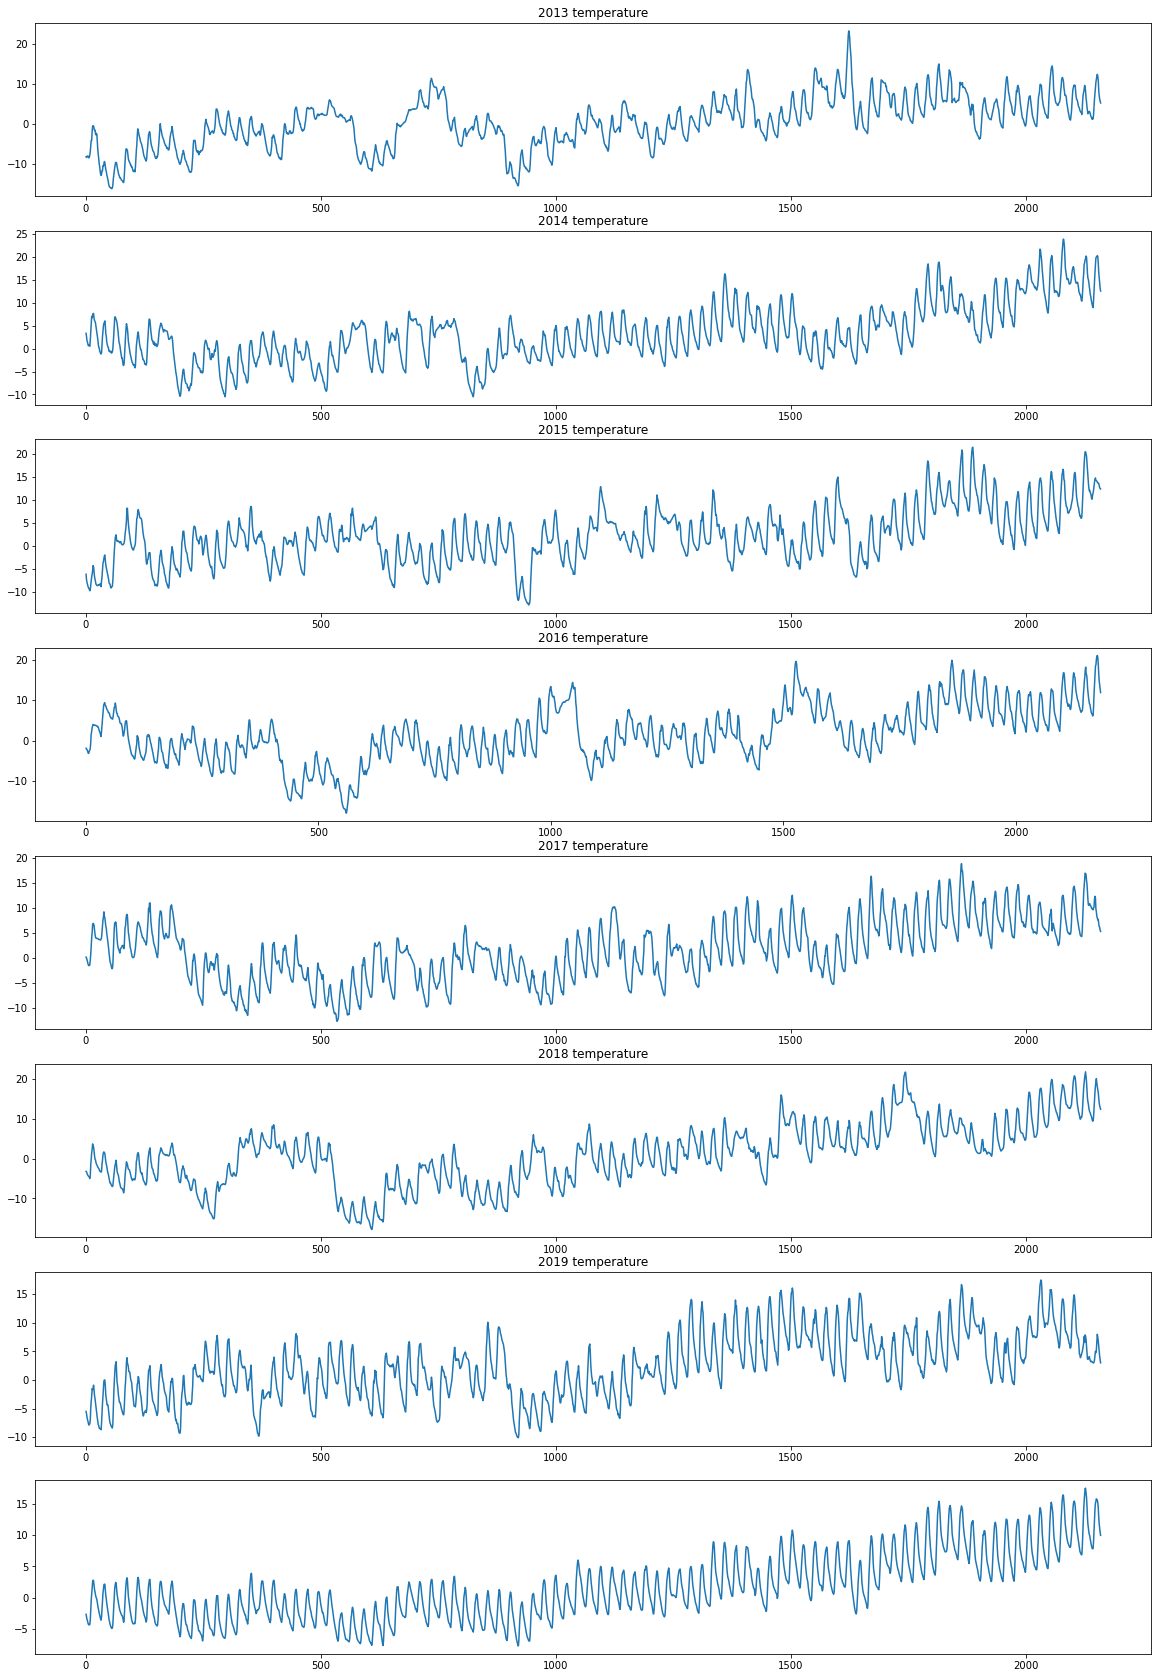

In [85]:
rcParams['figure.figsize'] = 20, 30
fig = plt.figure()

ax1 = fig.add_subplot(811)
ax2 = fig.add_subplot(812)
ax3 = fig.add_subplot(813)
ax4 = fig.add_subplot(814)
ax5 = fig.add_subplot(815)
ax6 = fig.add_subplot(816)
ax7 = fig.add_subplot(817)
ax8 = fig.add_subplot(818)

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]



for i in range(len(axes) - 2):
    axes[i].plot(temps[i][temps[i]['month'].isin([1,2,3])]['temperature'])
    axes[i].set_title('{} temperature'.format(temps[i]['year'].iloc[0]))

ax7.plot(temp_2019[temp_2019['month'].isin([1,2,3])]['temperature'])
ax7.set_title("2019 temperature")
#plt.plot(temps[4][temps[4]['month'].isin([1,2,3])]['temperature'])

ax8.plot(test_combined[test_combined['company'] == 1]['temperature'].reset_index(drop = True))

In [58]:
for i in range(len(temps)):
    print(abs(temps[i][temps[i]['month'].isin([1,2,3])]['temperature'] - temp_2019[temp_2019['month'].isin([1,2,3])]['temperature']).mean())


4.296250000000001
4.342638888888888
4.103055555555555
5.098287037037037
4.425787037037037
4.92037037037037


In [79]:
abs(test_combined[test_combined['company'] == 1]['temperature'].reset_index(drop=True) - temp_2019[temp_2019['month'].isin([1,2,3])]['temperature']).mean()

3.2783256172839508

In [87]:
for i in range(len(temps)):
    print(temps[i][temps[i]['month'].isin([1,2,3])]['temperature'].mean())
    print(temps[i][temps[i]['month'].isin([1,2,3])]['temperature'].std())
    print()



0.18370370370370379
6.225772546669046

3.0823148148148145
6.101646503501679

2.1490277777777775
5.848013956383737

1.3518315018315021
6.8432014228832605

1.4743518518518517
5.948023250579651

0.8947685185185189
7.717980392899897



In [88]:
print(temp_2019[temp_2019['month'].isin([1,2,3])]['temperature'].mean())
print(temp_2019[temp_2019['month'].isin([1,2,3])]['temperature'].std())


2.4372685185185183
5.4916429786567305


In [89]:
print(test_combined[test_combined['company'] == 1]['temperature'].mean())
print(test_combined[test_combined['company'] == 1]['temperature'].std())

1.5315817901234567
5.196447155161185
